# Boosted Exponential Smoothing Volatility Forecasts

This notebook corresponds to the blog post [Extending Smooth Transitioning Exponential Smoothing Volatility Forecasts](https://steveya.github.io/2024/07/12/volatility-forecast-1.html). The aim is to replace the logistic function used by the STES model with a xgboost model, and evaluate their relative performance. It is a work in progress and will be updated as I wrap up my implementations.

In [1]:
import numpy as np
import pandas as pd
from functools import partial
from scipy.optimize import minimize
from scipy.special import expit
from matplotlib import pyplot as plt
from operator import itemgetter
import yfinance as yf
import xgboost as xgb
import random

In [2]:
def simulate_contaminated_garch(n, mu, omega, alpha, beta, eta):
    returns = np.zeros(n)
    sigma2s = np.zeros(n)
    shocks = (np.random.uniform(0, 1, n) < 0.005).astype(float)
    for t in range(1, n):
        sigma2s[t] = omega + alpha * returns[t-1]**2 + beta * sigma2s[t-1]
        returns[t] = np.random.normal(mu, np.sqrt(sigma2s[t])) + eta * shocks[t]

    return returns, sigma2s

In [76]:
def es(params, returns):
    assert len(params) == 1
    n = len(returns)
    sigma2s = np.zeros(n)
    alphas = expit(params[0]) * np.ones(n)
    for t in range(1, n):
        sigma2s[t] = (1 - alphas[t-1]) * sigma2s[t-1] + alphas[t-1] * returns[t-1]**2
    
    return sigma2s, alphas

def stes_ae(params, returns):
    assert len(params) == 2
    n = len(returns)
    sigma2s = np.zeros(n)
    alphas = np.zeros(n)
    for t in range(1, n):
        features = np.array([1, abs(returns[t-1])])
        alpha = expit(params @ features)
        alphas[t-1] = alpha
        sigma2s[t] = (1 - alphas[t-1]) * sigma2s[t-1] + alphas[t-1] * returns[t-1]**2

    return sigma2s, alphas

def stes_se(params, returns):
    assert len(params) == 2
    n = len(returns)
    sigma2s = np.zeros(n)
    alphas = np.zeros(n)
    for t in range(1, n):
        features = np.array([1, returns[t-1]**2])
        alpha = expit(params @ features)
        alphas[t-1] = alpha
        sigma2s[t] = (1 - alphas[t-1]) * sigma2s[t-1] + alphas[t-1] * returns[t-1]**2

    return sigma2s, alphas

def stes_aese(params, returns):
    assert len(params) == 3
    n = len(returns)
    sigma2s = np.zeros(n)
    alphas = np.zeros(n)
    for t in range(1, n):
        features = np.array([1, abs(returns[t-1]), returns[t-1]**2])
        alpha = expit(params @ features)
        alphas[t-1] = alpha
        sigma2s[t] = (1 - alphas[t-1]) * sigma2s[t-1] + alphas[t-1] * returns[t-1]**2

    return sigma2s, alphas

def rmse(model, params, returns, is_index=500, os_index=2000):
    sigma2s, alphas = model(params, returns)
    
    sse = (returns ** 2 - sigma2s) ** 2
    is_rmse = np.sqrt(np.mean(sse[is_index:os_index]))
    os_rmse = np.sqrt(np.mean(sse[os_index:]))
    return is_rmse, os_rmse, sigma2s, alphas

def rmse2(model, params, returns, is_index=500, os_index=2000):
    sigma2s, alphas = model(params, returns)
    
    sse = (np.log(returns ** 2) - np.log(sigma2s)) ** 2
    is_rmse = np.sqrt(np.mean(sse[is_index:os_index]))
    os_rmse = np.sqrt(np.mean(sse[os_index:]))
    return is_rmse, os_rmse, sigma2s, alphas

def nllh(model, params, returns, is_index=500, os_index=2000):
    sigma2s, alphas = model(params, returns)
   
    llh = -np.log(sigma2s[2:]) - (returns[2:] ** 2 / sigma2s[2:])
    is_nllh = -np.sum(llh[is_index:os_index])
    os_nllh = -np.sum(llh[os_index:])
    return is_nllh, os_nllh, sigma2s, alphas



In [95]:
from scipy.optimize import least_squares
def rmse_ls(params, model, returns, is_index=500, os_index=2000):
    sigma2s, alphas = model(params, returns)
    sse = (returns ** 2 - sigma2s)
    residual = sse[is_index:os_index]
    return residual

np.random.seed(0)
for _ in range(10):
    lss = least_squares(partial(rmse_ls, model=stes_ae, returns=simulated_garch_return), x0=np.random.normal(0, 1, 2)) 
    print(lss.x)


[-2.0221339  -0.08051569]
[-2.02238798 -0.08049192]
[-2.02241352 -0.08048953]
[-2.02210412 -0.08051848]
[-2.02244303 -0.08048677]
[-2.02209052 -0.0805187 ]
[-2.02213362 -0.08051572]
[-2.022146   -0.08051456]
[-2.0223468  -0.08049572]
[-2.02212351 -0.08051664]


In [96]:

np.random.seed(0)
for _ in range(10):
    p, os_stes_ae_rmse, os_stes_ae_llh, _, _, is_stes_ae_rmse, _ = fit_stes_ae_rmse(returns=simulated_garch_return)
    print(p)

[-2.02220599 -0.08050869]
[-2.02220488 -0.08047502]
[-2.02228473 -0.08049398]
[-2.02241858 -0.08029311]
[-2.02199511 -0.08056591]
[61.2084316  46.39898717]
[-2.02227685 -0.08048086]
[-2.02257069 -0.08044655]
[-2.02243975 -0.08042189]
[-2.02381059 -0.08008213]


In [92]:
rmse(stes_ae, lss.x, simulated_garch_return, 500, 2000)

(3.0793895620521314,
 3.856693135509869,
 array([0.        , 0.        , 0.0099294 , ..., 0.31212147, 0.34332461,
        0.3848527 ]),
 array([0.23080602, 0.16836265, 0.15748929, ..., 0.005321  , 0.01085679,
        0.        ]))

In [108]:
def fit_model_old(model, metrics, param_dim, returns, is_index=500, os_index=2000):
    initial_params = np.random.normal(0, 1, size=param_dim)
    obj_func_inner = lambda *args, **kwargs: itemgetter(0)(partial(metrics, model)(*args, **kwargs))
    result = minimize(obj_func_inner, initial_params, args=(returns, is_index, os_index), method = 'SLSQP')
    
    if not result.success:
        raise ValueError("Optimization failed: " + result.message)
    
    is_mse, os_mse, sigmas, alphas = rmse(model,result.x, returns, is_index, os_index)
    is_llh, os_llh, _, _ = nllh(model, result.x, returns, is_index, os_index)
    return (result.x, os_mse, os_llh, sigmas, alphas, is_mse, is_llh)

def fit_model(model, metrics, param_dim, returns, is_index=500, os_index=2000):
    initial_params = np.random.normal(0, 1, size=param_dim)
    obj_func_inner = partial(rmse_ls, model=model, returns=returns, is_index=is_index, os_index=os_index)
    result = least_squares(obj_func_inner, initial_params)
    
    if not result.success:
        raise ValueError("Optimization failed: " + result.message)
    
    is_mse, os_mse, sigmas, alphas = rmse(model,result.x, returns, is_index, os_index)
    is_llh, os_llh, _, _ = nllh(model, result.x, returns, is_index, os_index)
    return (result.x, os_mse, os_llh, sigmas, alphas, is_mse, is_llh)


fit_es_rmse_old = partial(fit_model_old, model=es, metrics=rmse, param_dim=1)
fit_stes_ae_rmse_old = partial(fit_model_old, model=stes_ae, metrics=rmse, param_dim=2)
fit_stes_se_rmse_old = partial(fit_model_old, model=stes_se, metrics=rmse, param_dim=2)
fit_stes_aese_rmse_old = partial(fit_model_old, model=stes_aese, metrics=rmse, param_dim=3)

fit_es_rmse = partial(fit_model, model=es, metrics=rmse_ls, param_dim=1)
fit_stes_ae_rmse = partial(fit_model, model=stes_ae, metrics=rmse_ls, param_dim=2)
fit_stes_se_rmse = partial(fit_model, model=stes_se, metrics=rmse_ls, param_dim=2)
fit_stes_aese_rmse = partial(fit_model, model=stes_aese, metrics=rmse_ls, param_dim=3)

fit_es_llh = partial(fit_model, model=es, metrics=nllh, param_dim=1)
fit_stes_ae_llh = partial(fit_model, model=stes_ae, metrics=nllh, param_dim=2)
fit_stes_se_llh = partial(fit_model, model=stes_se, metrics=nllh, param_dim=2)
fit_stes_aese_llh = partial(fit_model, model=stes_aese, metrics=nllh, param_dim=3)

In [102]:
fit_es_rmse(returns=simulated_garch_return)

(array([-2.27230817]),
 3.416464296994357,
 748.1263407613558,
 array([0.        , 0.        , 0.00551089, ..., 1.00975411, 1.49252624,
        1.74256699]),
 array([0.0934425, 0.0934425, 0.0934425, ..., 0.0934425, 0.0934425,
        0.0934425]),
 2.7502018691956645,
 1467.451103112712)

In [104]:
fit_es_rmse_old(returns=simulated_garch_return)

(array([-2.27133947]),
 3.416447840401917,
 748.1297112632379,
 array([0.        , 0.        , 0.00551573, ..., 1.00997481, 1.49315043,
        1.74335248]),
 array([0.09352459, 0.09352459, 0.09352459, ..., 0.09352459, 0.09352459,
        0.09352459]),
 2.750201921015072,
 1467.4698630692208)

In [106]:

fit_stes_se_rmse(returns=simulated_garch_return)

(array([-2.06431227, -0.01514206]),
 3.40272272619349,
 751.7047756285671,
 array([0.        , 0.        , 0.0066363 , ..., 1.0275292 , 1.5609462 ,
        1.83853403]),
 array([0.11261418, 0.11252496, 0.11248516, ..., 0.10360146, 0.10645917,
        0.        ]),
 2.741536813961203,
 1477.8111925406965)

In [107]:
fit_stes_se_rmse_old(returns=simulated_garch_return)

(array([-2.06300134, -0.01526235]),
 3.4027134273148003,
 751.7456944489497,
 array([0.        , 0.        , 0.00664399, ..., 1.02757569, 1.56125953,
        1.83901484]),
 array([0.11274525, 0.11265523, 0.11261507, ..., 0.10365422, 0.1065362 ,
        0.        ]),
 2.741537247820002,
 1477.918476298767)

### Test STES and ES on Simulated Contaminated GARCH Data as in Taylor (2020)

In [110]:
np.random.seed(2)
np.random.seed(np.random.randint(0, 1e4, size=1))
simulated_garch_return, simulated_garch_var = simulate_contaminated_garch(n=2500, mu=0, omega=0.02, alpha=0.11, beta=0.87, eta=4)
_, os_stes_se_rmse, os_stes_se_llh, _, _, _, _ = fit_stes_se_rmse(returns=simulated_garch_return)
_, os_stes_ae_rmse, os_stes_ae_llh, _, _, _, _ = fit_stes_ae_rmse(returns=simulated_garch_return)
_,      os_es_rmse,      os_es_llh, _, _, _, _ = fit_es_rmse(returns=simulated_garch_return)
os_stes_se_rmse, os_stes_ae_rmse, os_es_rmse

(1.365253202967331, 1.365823107361304, 1.3617270367547378)

In [111]:
stes_ae_os_rmses = []
stes_se_os_rmses = []
es_os_rmses = []

stes_ae_os_llhs = []
stes_se_os_llhs = []
es_os_llhs = []

num_runs = 1000
np.random.seed(0)
rand_seeds = np.random.randint(0, 1e6, size=num_runs)
for i in range(num_runs):
    np.random.seed(rand_seeds[i])
    simulated_garch_return, simulated_garch_var = simulate_contaminated_garch(n=2500, mu=0, omega=0.02, alpha=0.11, beta=0.87, eta=4)
    _, os_stes_se_rmse, os_stes_se_llh, _, _, _, _ = fit_stes_se_rmse(returns=simulated_garch_return)
    _, os_stes_ae_rmse, os_stes_ae_llh, _, _, _, _ = fit_stes_ae_rmse(returns=simulated_garch_return)
    _,      os_es_rmse,      os_es_llh, _, _, _, _ = fit_es_rmse(returns=simulated_garch_return)
    stes_ae_os_rmses.append(os_stes_ae_rmse)
    stes_ae_os_llhs.append(os_stes_ae_llh)
    stes_se_os_rmses.append(os_stes_se_rmse)
    stes_se_os_llhs.append(os_stes_se_llh)
    es_os_rmses.append(os_es_rmse)
    es_os_llhs.append(os_es_llh)

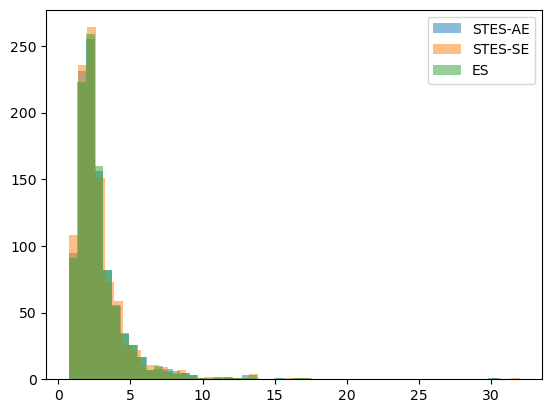

The mean of RMSE of the STES-AE model is 2.8452412258472464
The mean of RMSE of the STES-SE model is 2.8787248873818627
The mean of RMSE of the ES model is 2.85216396301645


In [112]:
plt.hist(stes_ae_os_rmses, bins=50, alpha=0.5, label='STES-AE')
plt.hist(stes_se_os_rmses, bins=50, alpha=0.5, label='STES-SE')
plt.hist(es_os_rmses, bins=50, alpha=0.5, label='ES')

plt.legend()
plt.show()

print(f"The mean of RMSE of the STES-AE model is {np.mean(stes_ae_os_rmses)}")
print(f"The mean of RMSE of the STES-SE model is {np.mean(stes_se_os_rmses)}")
print(f"The mean of RMSE of the ES model is {np.mean(es_os_rmses)}")


### Test STES and ES on SPY Returns

In [113]:
spy_adj_close = yf.download("SPY", start="2000-01-01", end="2023-12-31")
spy_log_returns = np.log(spy_adj_close["Adj Close"]).diff().dropna()

[*********************100%%**********************]  1 of 1 completed


In [114]:
spy_log_returns.shape

(6036,)

In [115]:
np.random.seed(0)
stes_aese_spy_res = [fit_stes_aese_rmse(returns=spy_log_returns.to_numpy(), is_index=10, os_index=4000) for _ in range(100)]


In [116]:
np.random.seed(0)
es_spy_res = [fit_es_rmse(returns=spy_log_returns.to_numpy(), is_index=10, os_index=4000) for _ in range(100)]

In [117]:
print(f"""
      STES AE&SE Parameter Estimated on SPY Returns using MLE: {np.mean([s[0] for s in stes_aese_spy_res], axis=0)},  
      Out-of-Sample Mean Squared Error = {np.mean([s[1] for s in stes_aese_spy_res]):.6f}, 
      Out-of-Sample Neg Log-Likelihood = {np.mean([s[2] for s in stes_aese_spy_res]):.6f}, 
      In-Sample Mean Squared Error = {np.mean([s[5] for s in stes_aese_spy_res]):.6f},
      In-Sample Neg Log-Likelihood = {np.mean([s[6] for s in stes_aese_spy_res]):.6f},
""")


      STES AE&SE Parameter Estimated on SPY Returns using MLE: [  -1.96842947   11.82264256 -161.82547101],  
      Out-of-Sample Mean Squared Error = 0.000450, 
      Out-of-Sample Neg Log-Likelihood = -17033.413333, 
      In-Sample Mean Squared Error = 0.000496,
      In-Sample Neg Log-Likelihood = -32546.800247,



In [118]:
print(f"""
      ES Parameter Estimated on SPY Returns using MLE: {np.mean([s[0] for s in es_spy_res], axis=0)},  
      Out-of-Sample Mean Squared Error = {np.mean([s[1] for s in es_spy_res]):.6f}, 
      Out-of-Sample Neg Log-Likelihood = {np.mean([s[2] for s in es_spy_res]):.6f}, 
      In-Sample Mean Squared Error = {np.mean([s[5] for s in es_spy_res]):.6f},
      In-Sample Neg Log-Likelihood = {np.mean([s[6] for s in es_spy_res]):.6f},
""")


      ES Parameter Estimated on SPY Returns using MLE: [-2.19081188],  
      Out-of-Sample Mean Squared Error = 0.000464, 
      Out-of-Sample Neg Log-Likelihood = -17037.883808, 
      In-Sample Mean Squared Error = 0.000500,
      In-Sample Neg Log-Likelihood = -32581.405164,



## Building XGBoost-Based Exponential Smoothing Model

In [121]:
class TimeSeriesDataIterator:
    def __init__(self, data, window_size):
        self.data = data
        self.window_size = window_size
        self.current_index = 0
        

    def __iter__(self):
        return self

    def __next__(self):
        if self.current_index + self.window_size > len(self.data):
            raise StopIteration
        
        start_index = self.current_index
        end_index = self.current_index + self.window_size
        window_data = self.data[start_index:end_index]
        self.current_index = end_index
        
        indices = list(range(start_index, end_index))
        return xgb.DMatrix(window_data.iloc[:, :-1], label=window_data.iloc[:, -1]), indices


class XGBoostExponentialSmoothing:
    def __init__(self, contiguous_subsample = 0.6,**xgb_params):
        self.xgb_params = xgb_params
        self.contiguous_subsample = contiguous_subsample
        self.model = None
        self.returns = None
        
    def rfes_variance_objective(self, preds, dtrain, indices):
        labels = dtrain.get_label()
        alphas = expit(preds)
        
        returns = self.data.iloc[indices]['returns']

        grads = np.zeros_like(preds)
        hesss = np.zeros_like(preds)
        varhs = np.zeros_like(preds)
        for t in range(len(returns)):
            if t == 0:
                varhs[t] = self.returns[0]**2
            else:
                varhs[t] = alphas[t] * returns[t]**2 + (1 - alphas[t]) * varhs[t-1]
            
            d_alpha = returns[t]**2 - varhs[t]
            d_pred = alphas[t] * (1 - alphas[t]) * d_alpha
            grads[t] = 2 * (varhs[t] - labels[t]) * d_pred
            hesss[t] = 2 * d_pred**2

        return grads, hesss

    def contiguous_subsample(self, n_samples, subsample_size):
        start = random.randint(0, n_samples - subsample_size)
        return list(range(start, start + subsample_size))

    def fit(self, X):
        assert 'label' in X
        assert 'returns' in X
        
        self.data = X

        dtrain = xgb.DMatrix(X)
        
        iterator = TimeSeriesDataIterator(self.data, self.contiguous_subsample)

        # Remove num_boost_round from xgb_params if it's there
        num_boost_round = self.xgb_params.pop('num_boost_round', 100)
        
        self.xgb_params.update({
            'objective': 'reg:squarederror',  # We'll override this with our custom objective
        })
        
        self.model = xgb.train(
            self.xgb_params,
            dtrain,
            num_boost_round=num_boost_round,
            obj=self.rfes_variance_objective,
            evals=[(dtrain, 'train')],
            verbose_eval=False
        )

        self.model = None
        for _ in range(num_boost_round):
            for dtrain, indices in iterator:
                if self.model is None:
                    self.model = xgb.train(self.xgb_params, dtrain, num_boost_round=1, obj=lambda preds, dtrain: self.rfes_variance_objective(preds, dtrain, indices), evals=[(dtrain, 'train')])
                else:
                    self.model = xgb.train(self.xgb_params, dtrain, num_boost_round=1, obj=lambda preds, dtrain: self.rfes_variance_objective(preds, dtrain, indices), evals=[(dtrain, 'train')], xgb_model=self.model)
        return self.model



    def custom_train(params, iterator, num_boost_round, custom_obj):
        bst = None
        for _ in range(num_boost_round):
            for dtrain, augment_data, indices in iterator:
                if bst is None:
                    bst = xgb.train(params, dtrain, num_boost_round=1, obj=lambda preds, dtrain: custom_obj(preds, dtrain, augment_data))
                else:
                    bst = xgb.train(params, dtrain, num_boost_round=1, obj=lambda preds, dtrain: custom_obj(preds, dtrain, augment_data), xgb_model=bst)
        return bst

    def predict(self, X):
        dtest = xgb.DMatrix(X)
        preds = self.model.predict(dtest)
        return preds

    def forecast_variance(self, X, returns):
        alphas = expit(self.predict(X))
        
        var_pred = np.zeros_like(alphas)
        var_pred[0] = returns[0]**2
        
        for t in range(1, len(returns)):
            var_pred[t] = alphas[t-1] * returns[t-1]**2 + (1 - alphas[t-1]) * var_pred[t-1]
        
        return var_pred


In [123]:
simulated_garch_feature_matrix = pd.DataFrame.from_dict({
    'returns': simulated_garch_return[:-1],
    'abs(returns)': np.abs(simulated_garch_return[:-1]),
    'returns^2': simulated_garch_return[:-1]**2,
    'label': simulated_garch_return[1:]**2,
}).to_numpy()

rfes_model = XGBoostExponentialSmoothing(**xgb_params)
rfes_model.fit(simulated_garch_feature_matrix[500:2000, :], simulated_garch_return[500:2000])


NameError: name 'xgb_params' is not defined

In [129]:
xgb_params = {
    'max_depth': 3,
    'learning_rate': 0.1,
    'num_boost_round': 100,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'tree_method': 'hist'
}

rfes_os_rmses = []
es_os_rmses = []

for _ in range(10):
    simulated_garch_return, simulated_garch_var = simulate_contaminated_garch(n=2500, mu=0, omega=0.02, alpha=0.11, beta=0.87, eta=4)
    simulated_garch_feature_matrix = pd.DataFrame.from_dict({
        'returns': simulated_garch_return,
        'abs(returns)': np.abs(simulated_garch_return),
        'returns^2': simulated_garch_return**2
    }).to_numpy()
    
    rfes_model = XGBoostExponentialSmoothing(**xgb_params)
    rfes_model.fit(simulated_garch_feature_matrix[500:2000, :], simulated_garch_return[500:2000])

    rfes_predicted_var_fs = rfes_model.forecast_variance(simulated_garch_feature_matrix, simulated_garch_return)

    os_rfes_rmse = np.sqrt(np.mean((rfes_predicted_var_fs[-500:] - simulated_garch_return[-500:]**2)**2))
    _, os_es_rmse, _, _, _, _, _ = fit_es_rmse(returns=simulated_garch_return)

    rfes_os_rmses.append(os_rfes_rmse)
    es_os_rmses.append(os_es_rmse)


0 [0. 0. 0. ... 0. 0. 0.]


TypeError: Booster.update() takes from 3 to 4 positional arguments but 5 were given

In [85]:
rfes_os_rmses

[2.1967439677439975,
 4.083961575943718,
 3.977190786992224,
 1.343855580223196,
 3.194381126038081,
 2.4422362440990644,
 1.482285080216327,
 3.696360343865444,
 3.4992941726343414,
 2.561489769347956]

In [86]:
es_os_rmses

[2.1114076722494652,
 3.8664190052721557,
 3.486855326498436,
 1.3523297754700163,
 2.641313255369907,
 2.306126203408118,
 1.254548978273125,
 3.7068204927230037,
 3.3559386112757985,
 2.3869755462220383]

In [103]:
spy_feature_matrix

,returns,abs(returns),returns^2
Date,,,
2000-01-04,-0.039891,0.039891,1.591289e-03
2000-01-05,0.001787,0.001787,3.192087e-06
2000-01-06,-0.016201,0.016201,2.624878e-04
2000-01-07,0.056452,0.056452,3.186843e-03
2000-01-10,0.003425,0.003425,1.173123e-05
...,...,...,...
2023-12-22,0.002008,0.002008,4.030817e-06
2023-12-26,0.004214,0.004214,1.775479e-05
2023-12-27,0.001806,0.001806,3.263419e-06


In [110]:
xgb_params = {
    'max_depth': 3,
    'learning_rate': 0.1,
    'num_boost_round': 100,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'tree_method': 'hist'
}

rfes_spy_os_rmses = []
es_spy_os_rmses = []

spy_feature_matrix = pd.DataFrame.from_dict({
    'returns': spy_log_returns,
    'abs(returns)': np.abs(spy_log_returns),
    'returns^2': spy_log_returns**2
})
for _ in range(10):
    rfes_spy_model = XGBoostExponentialSmoothing(**xgb_params)
    rfes_spy_model.fit(spy_feature_matrix.iloc[:3000,:].to_numpy(), spy_log_returns[:3000].to_numpy())

    rfes_predicted_spy_var_fs = rfes_spy_model.forecast_variance(spy_feature_matrix.to_numpy(), spy_log_returns.to_numpy())

    os_rfes_spy_rmse = np.sqrt(np.mean((rfes_predicted_spy_var_fs[3000:] - spy_log_returns[3000:].to_numpy()**2)**2))
    _, os_es_spy_rmse, _, _, _, _, _ = fit_es_rmse(returns=spy_log_returns, is_index=0, os_index=3000)

    rfes_spy_os_rmses.append(os_rfes_spy_rmse)
    es_spy_os_rmses.append(os_es_spy_rmse)


/var/folders/rg/8kd3fpqx30g12g_zg6kb7w0r0000gn/T/ipykernel_34222/3755127255.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sigma2s[t] = (1 - alphas[t-1]) * sigma2s[t-1] + alphas[t-1] * returns[t-1]**2


In [111]:
rfes_spy_os_rmses, es_spy_os_rmses

([0.0004709580368269481,
  0.0004709580368269481,
  0.0004709580368269481,
  0.0004709580368269481,
  0.0004709580368269481,
  0.0004709580368269481,
  0.0004709580368269481,
  0.0004709580368269481,
  0.0004709580368269481,
  0.0004709580368269481],
 [0.0004970372970689315,
  0.00047754965159836865,
  0.0004436192778102199,
  0.00046522509899032347,
  0.00045956441904994766,
  0.00044527986166702395,
  0.00045161747828409134,
  0.0004497941587374528,
  0.0004436180529244832,
  0.0004437230613194157])

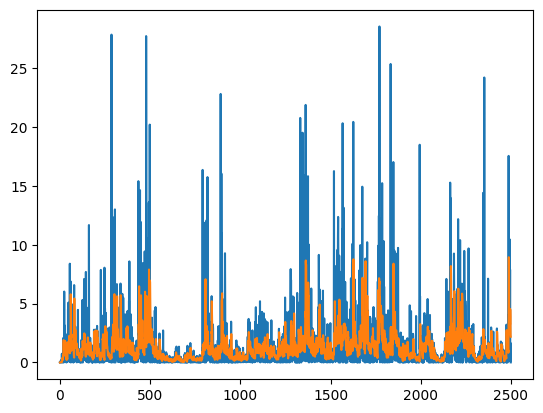

In [76]:
plt.plot(simulated_garch_return**2)
plt.plot(rfes_predicted_var_fs)


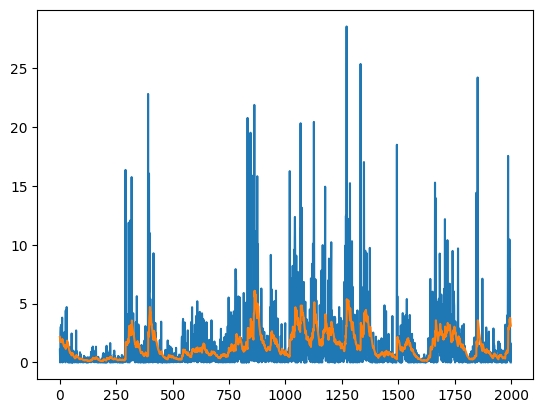

In [75]:
plt.plot(simulated_garch_return[500:]**2)
plt.plot(fit_es_rmse(returns=simulated_garch_return)[3][500:])


In [ ]:
rfes_os_rmses = []
es_os_rmses = []
for _ in range(500):
    simulated_garch_return, simulated_garch_var = simulate_contaminated_garch(n=2500, mu=0, omega=0.02, alpha=0.11, beta=0.87, eta=4)
    _,      os_es_rmse,      os_es_llh, _, _, _, _ = fit_es_rmse(returns=simulated_garch_return)
    rfes_os_rmses.append(os_stes_ae_rmse)
    rfes_os_llhs.append(os_stes_ae_llh)
    es_os_rmses.append(os_es_rmse)
    es_os_llhs.append(os_es_llh)

In [59]:

# Usage
xgb_params = {
    'max_depth': 3,
    'learning_rate': 0.1,
    'num_boost_round': 100,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'tree_method': 'hist'
}
model = XGBoostExponentialSmoothing(**xgb_params)
model.fit(X, simulated_garch_return)

NameError: name 'X' is not defined

In [ ]:

predicted_alphas = model.predict(X_new)
predicted_var = model.forecast_variance(X_new, returns_new)